<hr>
<hr>
<B>TASK 8: NEXT WORD PREDICTION</B>
<HR>
    <HR>

- <b> Importing libraries👇</b>

In [33]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense, Activation, Dropout, RepeatVector
from tensorflow.keras.optimizers import  RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

- <b> Load Data👇</b>

In [34]:
txt = open("SherlockHolmes.txt",encoding='utf8').read().lower()
print("corpus length: ",len(txt))

corpus length:  581888


- <b>Data Preprocessing 👇</b>

In [35]:
character = sorted(list(set(txt)))
char_indices = dict((c, i) for i, c in enumerate(character))
indices_char = dict((i, c) for i, c in enumerate(character))
 
print(f'unique chars: {len(character)}')

unique chars: 73


In [36]:
seq_len = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(txt) - seq_len, step):
    sentences.append(txt[i: i + seq_len ])
    next_chars.append(txt[i + seq_len])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


- <b>One hot Encoding 👇</b>

In [38]:
X = np.zeros((len(sentences), seq_len, len(character)), dtype=bool)
y = np.zeros((len(sentences), len(character)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sentences[124]
next_chars[100]

'e'

- <b>One hot encoded data 👇</b>

In [39]:
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True]


In [41]:
print(y[0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False]


- <b>Creating a Model 👇</b>

In [42]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [45]:
model.summary()
from tensorflow.keras.utils import plot_model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               103424    
                                                                 
 dense_1 (Dense)             (None, 73)                9417      
                                                                 
 activation_1 (Activation)   (None, 73)                0         
                                                                 
Total params: 112,841
Trainable params: 112,841
Non-trainable params: 0
_________________________________________________________________


- <b> Training our model👇</b>

In [46]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y,
                    validation_split=0.01, 
                    batch_size=128,
                    epochs=30, 
                    shuffle=True).history

Epoch 1/30
1501/1501 [==============================] - 128s 80ms/step - loss: 1.9430 - accuracy: 0.4284 - val_loss: 2.1810 - val_accuracy: 0.3912
Epoch 2/30
1501/1501 [==============================] - 118s 79ms/step - loss: 1.6102 - accuracy: 0.5180 - val_loss: 2.0760 - val_accuracy: 0.4546
Epoch 3/30
1501/1501 [==============================] - 135s 90ms/step - loss: 1.5167 - accuracy: 0.5437 - val_loss: 2.0048 - val_accuracy: 0.4521
Epoch 4/30
1501/1501 [==============================] - 134s 89ms/step - loss: 1.4671 - accuracy: 0.5581 - val_loss: 1.9848 - val_accuracy: 0.4675
Epoch 5/30
1501/1501 [==============================] - 124s 82ms/step - loss: 1.4361 - accuracy: 0.5649 - val_loss: 1.9679 - val_accuracy: 0.4732
Epoch 6/30
1501/1501 [==============================] - 116s 77ms/step - loss: 1.4120 - accuracy: 0.5710 - val_loss: 1.9793 - val_accuracy: 0.4706
Epoch 7/30
1501/1501 [==============================] - 113s 75ms/step - loss: 1.3951 - accuracy: 0.5763 - val_loss: 1

- <b> Save the model👇</b>

In [47]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

- <b> Loading the model👇</b>

In [48]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

- <b> Model Evaluation👇</b>

In [49]:
loss_and_acc=model.evaluate(X,y)
print("Test Loss", loss_and_acc[0])
print("Test Accuracy", loss_and_acc[1])

6061/6061 [==============================] - 109s 18ms/step - loss: 1.2343 - accuracy: 0.6194
Test Loss 1.234304428100586
Test Accuracy 0.6193554997444153


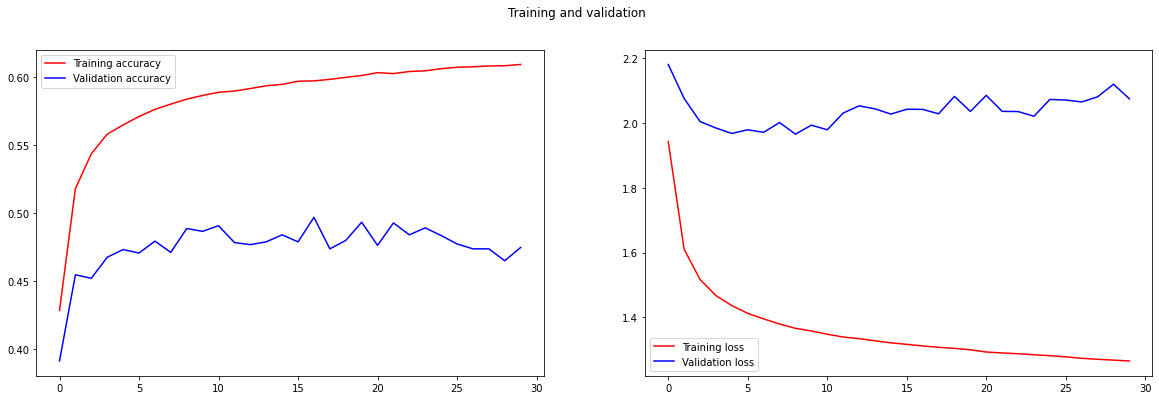

In [50]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

 - <b> To achieve next probable characters 👇</b>

In [51]:
def prepare_input(text):
    x = np.zeros((1, seq_len, len(character)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

prepare_input("This is an example of input of our model".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [52]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [53]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [54]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

 - <b>Prediction 👇</b>

In [55]:
quotes = [   
    "Deep learning is subset of machine learning,which is essentially a neural network with three or more layers.",
    "Machine learning  is the study of computer algorithms that improve automatically through experience and by the use of data.",
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "Recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.",
    "Thanks for spending your precious time to view my work."  
    
]

In [56]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

deep learning is subset of machine learn
[' of ', 'er ', ', ', '. ', 's ']

machine learning  is the study of comput
['ing ', 'led ', 'ence ', 'ter ', 'sunce ']

it is not a lack of love, but a lack of 
['the ', 'a ', 'his ', 'my ', 'some ']

recurrent neural network (rnn) is a type


<ipython-input-52-bf39724b6161>:3: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds)


['wjent ', 'arure ', 'jectroner ', 'husb ', 'brough ']

thanks for spending your precious time t
['he ', 'o ', 'alk ', 'erribly. ', 'race ']

